# Image Classification


One of the major uses of convolutional neural networks is image classification, where the network learns to identify what is there in the image presented to it, and then classifies the image into categories given to it. In this interactive python notebook, we look at a binary classification problem of [ships in satellite imagery](https://www.kaggle.com/rhammell/ships-in-satellite-imagery) taken from Kaggle. The data has 4000 satellite images of the San Francisco Bay and San Pedro Bay, where each image has a ship, or is some other random feature. The task is to classify the image accordingly as ship, or no ship.

We start by importing the usual libraries, `json` for reading the data from Kaggle, `numpy` & `matplotlib` for data handling and plotting, and the TensorFlow and Keras frameworks for the learning model.

In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

Using TensorFlow backend.


Here, we use some code bits to retrieve the data from Kaggle. In case you have never done so before, check out [this article](https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463) from Towards Data Science. The Kaggle forums might also have a solution if you run into any trouble.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [16]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery -p /content

 97% 179M/185M [00:00<00:00, 242MB/s]
100% 185M/185M [00:00<00:00, 253MB/s]


In [17]:
!unzip \*.zip

Archive:  ships-in-satellite-imagery.zip
  inflating: scenes/scenes/lb_1.png  
  inflating: scenes/scenes/lb_2.png  
  inflating: scenes/scenes/lb_3.png  
  inflating: scenes/scenes/lb_4.png  
  inflating: scenes/scenes/sfbay_1.png  
  inflating: scenes/scenes/sfbay_2.png  
  inflating: scenes/scenes/sfbay_3.png  
  inflating: scenes/scenes/sfbay_4.png  
  inflating: shipsnet.json           
  inflating: shipsnet/shipsnet/0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png  
  inflating: shipsnet/shipsnet/0__20150718_184300_090b__-122.38458613431831_37.763521076612484.png  
  inflating: shipsnet/shipsnet/0__20150718_184300_090b__-122.40477488428849_37.8071040053892.png  
  inflating: shipsnet/shipsnet/0__20150718_184300_090b__-122.42663861582857_37.80913223576201.png  
  inflating: shipsnet/shipsnet/0__20150720_184302_0906__-122.21893759782994_37.87172273326103.png  
  inflating: shipsnet/shipsnet/0__20150830_000650_0b07__-122.37967271362145_37.76049394246638.png  
  in

In [0]:
f = open(r'shipsnet.json')
dataset = json.load(f)
f.close()

Now we load the data from the json provided and arrange it into some nice numpy arrays for our purposes. We take a look at the shape to make sure everything is fine, then we reshape the images into the $80 \times 80$ size as mentioned by the dataset author. Finally we load the images and training labels into their variables. The labels are all arrays of size 2, which prompts us to use a softmax classifier instead of a sigmoid.

In [0]:
data = np.array(dataset['data']).astype('uint8')
labels = np.array(dataset['labels']).astype('uint8')

In [20]:
data.shape, labels.shape

((4000, 19200), (4000,))

In [0]:
x = data / 255.
x = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
y = to_categorical(labels, num_classes=2)

In [22]:
x.shape, y.shape

((4000, 80, 80, 3), (4000, 2))

Now we take a quick peek at our dataset using the `ImageGrid()` class from matplotlib toolkits, we plot 15 random images labelled if they have a ship or not.

In [0]:
img_id = [np.random.randint(0, x.shape[0] - 1) for i in range(15)]
img = [x[i] for i in img_id]

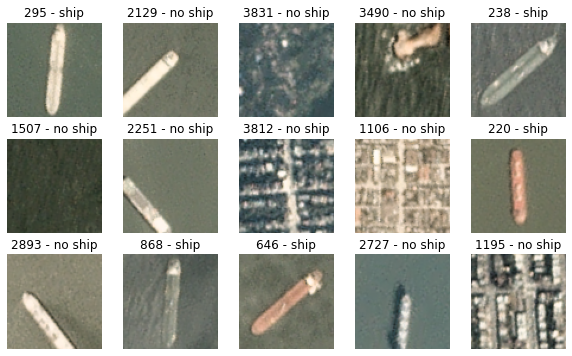

In [24]:
fig = plt.figure(figsize=(10, 6))
plt.axis('off')

grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 5),
                 axes_pad=0.3,
                 )

it = 0
stem = ''
for ax, im in zip(grid, img):
    ax.imshow(im)
    ax.set_axis_off()

    if (y[img_id[it]][0] == 0):
        stem = 'ship'
    else:
        stem = 'no ship'
        
    ax.set_title(str(img_id[it]) + ' - ' + stem)
    it += 1

plt.show()

Now we get to building the model, and here we can twist and play with the layers we use. Using no dropouts causes the data to start overfitting, while using no dropouts causes weird behaviour. So we use one dropout after the double convolutional layers in the start with an unusual filter size of 7, which seems to work pretty well. The other layers are the usual pooling, followed by double convolution twice, then flattened and dense connected with a softmax finally for the output. We can take a look at the model summary, and this model was one of the better models under 1 million parameters but may not be the best.

In [0]:
model = Sequential([
    Conv2D(16, 7, padding='same', activation='relu', input_shape=(80, 80 ,3)),
    Conv2D(16, 7, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

In [134]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 80, 80, 16)        2368      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 74, 74, 16)        12560     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 37, 37, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 37, 37, 32)        4640      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 32)       

Now we define two optimizers - the Stochastic Gradient Descent (SGD) and the Adam optimizer and pit them against each other. The hyperparamters for each can be tweaked below.

In [0]:
opt1 = SGD(lr=0.01, momentum=0.9)
opt2 = Adam(lr=0.002)

### Training with SGD

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=opt1, metrics=['accuracy'])

In [137]:
hist1 = model.fit(x, y, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
100/100 [==============================] - 2s 23ms/step - loss: 0.3716 - accuracy: 0.8297 - val_loss: 0.2258 - val_accuracy: 0.9112
Epoch 2/20
100/100 [==============================] - 2s 21ms/step - loss: 0.2130 - accuracy: 0.9191 - val_loss: 0.7267 - val_accuracy: 0.6800
Epoch 3/20
100/100 [==============================] - 2s 22ms/step - loss: 0.1234 - accuracy: 0.9522 - val_loss: 0.4517 - val_accuracy: 0.7937
Epoch 4/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0698 - accuracy: 0.9797 - val_loss: 0.2922 - val_accuracy: 0.8650
Epoch 5/20
100/100 [==============================] - 2s 22ms/step - loss: 0.0527 - accuracy: 0.9822 - val_loss: 0.4908 - val_accuracy: 0.8087
Epoch 6/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0527 - accuracy: 0.9862 - val_loss: 0.1691 - val_accuracy: 0.9438
Epoch 7/20
100/100 [==============================] - 2s 22ms/step - loss: 0.0375 - accuracy: 0.9875 - val_loss: 0.3413 - val_accuracy: 0.8825

In [0]:
sgd_acc = hist1.history['accuracy']
sgd_val_acc = hist1.history['val_accuracy']
sgd_loss = hist1.history['loss']
sgd_val_loss = hist1.history['val_loss']

### Training with Adam

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])

In [140]:
hist2 = model.fit(x, y, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
100/100 [==============================] - 2s 23ms/step - loss: 0.0725 - accuracy: 0.9847 - val_loss: 0.3370 - val_accuracy: 0.9050
Epoch 2/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0344 - accuracy: 0.9887 - val_loss: 0.0958 - val_accuracy: 0.9725
Epoch 3/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0260 - accuracy: 0.9925 - val_loss: 0.5306 - val_accuracy: 0.8700
Epoch 4/20
100/100 [==============================] - 2s 22ms/step - loss: 0.0294 - accuracy: 0.9916 - val_loss: 0.2805 - val_accuracy: 0.9038
Epoch 5/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 0.5707 - val_accuracy: 0.9375
Epoch 6/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0471 - accuracy: 0.9875 - val_loss: 0.1602 - val_accuracy: 0.9450
Epoch 7/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0285 - accuracy: 0.9931 - val_loss: 0.4560 - val_accuracy: 0.8913

In [0]:
adam_acc = hist2.history['accuracy']
adam_val_acc = hist2.history['val_accuracy']
adam_loss = hist2.history['loss']
adam_val_loss = hist2.history['val_loss']

Finally we plot the accuracy and the loss for the model to evaluate its performance on training and validation. While there are still signs of overfitting for both optimizers, the Adam optimizer seems to outperform the SGD optimizer on validation accuracy and loss.

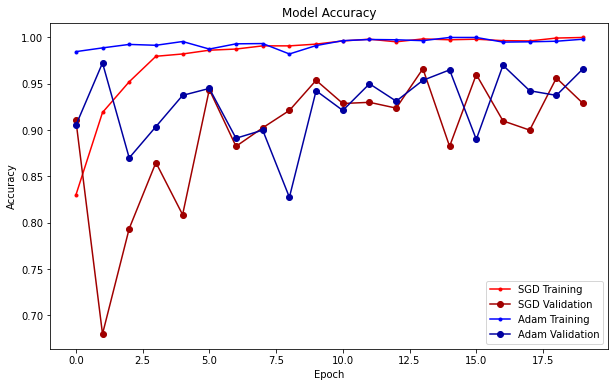

In [142]:
fig1 = plt.figure(figsize=(10, 6))
plt.plot(sgd_acc, '.-', color='#ff0000')
plt.plot(sgd_val_acc, 'o-', color='#a00000')
plt.plot(adam_acc, '.-', color='#0000ff')
plt.plot(adam_val_acc, 'o-', color='#0000a0')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['SGD Training', 'SGD Validation', 'Adam Training', 'Adam Validation'], loc='best')
plt.show()

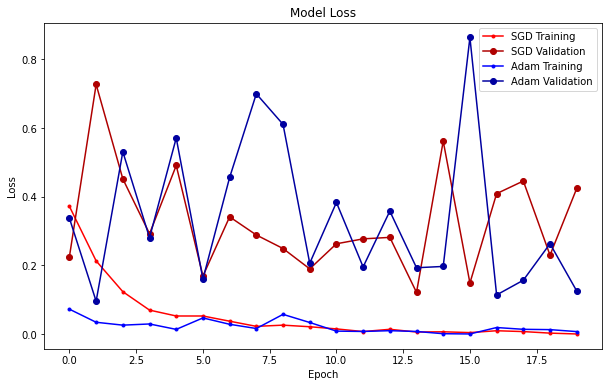

In [143]:
fig2 = plt.figure(figsize=(10, 6))
plt.plot(sgd_loss, '.-', color='#ff0000')
plt.plot(sgd_val_loss, 'o-', color='#af0000')
plt.plot(adam_loss,'.-', color='#0000ff')
plt.plot(adam_val_loss, 'o-', color='#0000a0')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['SGD Training', 'SGD Validation', 'Adam Training', 'Adam Validation'], loc='best')
plt.show()

In [0]:
from google.colab import files
fig1.savefig('accuracy.png')
files.download('accuracy.png')
fig2.savefig('loss.png')
files.download('loss.png')